In [1]:
%matplotlib inline
import fasta_subseq_2 as fa
import seq_plotmethods as sp
import itertools as it
import tables as tb
import numpy as np
import subprocess as subp
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import gzip
import tarfile
import re
import patser_tools as pat
#import matplotlib_venn as vn 
import os
import shutil
from __future__ import division
from skimage import io as skio
from skimage import transform as skxform

# set up plotting environment for LaTeX compatability
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')

# Define chromosome names for dmel and dpse
DMEL_CHRS = ['2L','2R','3L','3R','X','YHet','4','2LHet','2RHet','3LHet','3RHet','XHet','U','Uextra']
DMEL_CHRS_EU = ['2L','2R','3L','3R','X']

current_dir = "/Users/barricklab/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/"
genomes_dir = current_dir + "genomes/"
reads_dir = current_dir + "reads/"
data_out_dir = current_dir + "data/"
figs_dir = current_dir + "figs/"
scripts_dir = current_dir + "scripts/"
mapping_dir = data_out_dir + "mapping/"
peaks_dir = data_out_dir + "peaks/"
h5_dir = data_out_dir + "hf5/"



In [10]:
# From Previous Fig. 5
dm_fa = fa.FastaDB("/Users/barricklab/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/genomes/dmel.fa")

def summit_window_seq(name,peaks,win,genome):
    # write sequences to fasta for MEME analysis
    wd = "/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/Figures/Fig5_sequence_correlates/meme_seqs/"
    seq_out = open("%s%s_win%d_seqs.fa" % (wd,name,win),"w")
    for p in peaks:
        start = p['summit'] - int(win/2)
        end = p['summit'] + win - int(win/2) 
        seq = genome[p['chr']][start:end]
        print >> seq_out, ">%s_%d-%d %s\n%s" % (p['chr'],start,end,name,seq)

def pks_patser_hits_rebuild(pks,matrix_file,fastadb,flank=0,patser_cutoff=None):
     
    phits = pd.DataFrame(columns=["matrix","parent_start","parent_end","parent_chr","parent_summit","motif_start","motif_end","pval_cutoff","pval","score","score_cutoff","strand"])
    # concatenate peak sequences
    all_seqs = ""
    seq_idx = []
    cur_len = 0
    for p in pks:
        seq = fastadb[p['chr']][p['start']:p['end']]
        seq_coords = (cur_len,cur_len+len(seq))
        all_seqs = all_seqs + seq
        cur_len += len(seq)
        seq_idx.append(seq_coords)
    print len(all_seqs)
    
    p_annot = pat.makePatserAnnotation(sequence=all_seqs,matrix=matrix_file,scorecut=patser_cutoff)
    p_sites = p_annot.getFeaturesByType('BindingSiteFeature')
    [s.tags.update({'pval':None,'pvalcut':None}) for s in p_sites if 'pval' not in s.tags.keys()]
    p_sites_dict = [{'matrix':s.tags['motif_name'],
                         'parent_start':None,
                         'parent_end':None,
                         'parent_chr':None,
                         'parent_summit':None,
                         'motif_start':s.start,
                         'motif_end':s.end,
                         'pval_cutoff':s.tags['pvalcut'],
                         'pval':s.tags['pval'],
                         'score':s.tags['score'],
                         'score_cutoff':s.tags['scorecut'],
                         'strand':s.tags['strand']} for s in p_sites]
    p_sites_lists = {}
    for k in p_sites_dict[0].keys():
        p_sites_lists[k] = [x[k] for x in p_sites_dict]
    phits_raw = pd.DataFrame(data=p_sites_lists)
    print "sites =%d,%d" % (phits_raw.shape[0],phits_raw.shape[1])
    for (i,(st,end)) in enumerate(seq_idx):
        seq_hits = phits_raw[(phits_raw['motif_start'] >= st) &
                             (phits_raw['motif_end'] <= end)]
        p = pks[i]
        if len(seq_hits) > 0:
            seq_hits['motif_start'] = seq_hits['motif_start'] - st
            seq_hits['motif_end'] = seq_hits['motif_end'] - st
            seq_hits['parent_start'] = p['start']
            seq_hits['parent_end'] = p['end']
            seq_hits['parent_chr'] = p['chr']
            seq_hits['parent_summit'] = p['summit']
            #print "%s:%d-%d %d hits" % (p['chr'],p['start'],p['end'],seq_hits.shape[0])
            phits = phits.append(seq_hits,ignore_index=True)
    return phits

def pks_patser_hits(pks,matrix_file,fastadb,flank=0,patser_cutoff=None):
    phits = pd.DataFrame(columns=["matrix","parent_start","parent_end","parent_chr","motif_start","motif_end","pval_cutoff","pval","score","score_cutoff","strand"])
    for p in pks:
        seq = fastadb[p['chr']][p['start']:p['end']]
        p_annot = pat.makePatserAnnotation(sequence=seq,matrix=matrix_file,scorecut=patser_cutoff)
        p_sites = p_annot.getFeaturesByType('BindingSiteFeature')
        [s.tags.update({'pval':None,'pvalcut':None}) for s in p_sites if 'pval' not in s.tags.keys()]
        p_sites_dict = [{'matrix':s.tags['motif_name'],
                         'parent_start':p['start'],
                         'parent_end':p['end'],
                         'parent_chr':p['chr'],
                         'motif_start':s.start,
                         'motif_end':s.end,
                         'pval_cutoff':s.tags['pvalcut'],
                         'pval':s.tags['pval'],
                         'score':s.tags['score'],
                         'score_cutoff':s.tags['scorecut'],
                         'strand':s.tags['strand']} for s in p_sites]
        if len(p_sites_dict) > 0:
            p_sites_lists = {}
            for k in p_sites_dict[0].keys():
                p_sites_lists[k] = [x[k] for x in p_sites_dict]
            #print len(p_sites_lists)
            phits = phits.append(pd.DataFrame(data=p_sites_lists),ignore_index=True)
            #print phits.shape
        """
'pval_cutoff':s.tags['pvalcut'],
                         'pval':s.tags['pval'],
{'matwidth': 11, 'motif_name': 'hb_SOLEXA_5', 'pvalcut': -8.947, 'pval': -5.89, 'score': 1.23, 'scorecut': 0.0, 'strand': '+'}
        r_sites = []
        l_sites = []
        if flank > 0:
            l_fl_seq = fastadb[p['chr']][p['start']-flank:p['start']]
            r_fl_seq = fastadb[p['chr']][p['end']:p['end']+flank]
            l_annot = pat.makePatserAnnotation(sequence=l_fl_seq,matrix=matrix_file, scorecut=patser_cutoff)
            r_annot = pat.makePatserAnnotation(sequence=rl_fl_seq,matrix=matrix_file, scorecut=patser_cutoff)
            l_sites = l_annot.getFeaturesByType('BindingSiteFeature')
            r_sites = l_annot.getFeaturesByType('BindingSiteFeature')
        phits.append(p_sites)
        """
    return phits


def build_nmer_profile(pks,win,n,fastadb):
    bases = ['A','T','G','C']
    rc = {'A':'T','C':'G','G':'C','T':'A'}
    nmer_decode_pr = it.product(bases,repeat=n)
    stop = False
    nmer_decode = []
    while not stop:
        try:
            nmer = nmer_decode_pr.next()
            nmer_rc = [rc[x] for x in reversed(nmer)]
            if "".join(nmer_rc) not in nmer_decode:
                nmer_decode.append("".join(nmer))
        except StopIteration:
            stop = True
    #print len(nmer_decode)
    nmer_code = dict([(x,i) for (i,x) in enumerate(nmer_decode)])
    print len(nmer_code)
    nmer_code.update([(x,i) for (i,x) in enumerate(["".join([rc[y] for y in reversed(list(z))]) for z in nmer_decode])])
    print len(nmer_code)
    #print nmer_code
    #print nmer_code['CCCCCA']
    #print nmer_decode[4095]
    print nmer_code
    profiles = []
    locations = []
    totals = np.zeros(len(nmer_decode))
    for p in pks:
        nmer_ar = np.zeros(len(nmer_decode))
        seq = fastadb[p['chr']][p['summit']-int(win/2):p['summit']+int(win/2)]
            
        for i in range(0,len(seq)-(n-1)):
            subseq = seq[i:i+n]
            if re.search('[^ACGTacgt]',subseq):
                continue
            nmer_ar[nmer_code[subseq]] += 1
        profiles.append(nmer_ar)
        totals += nmer_ar
    return (np.array(profiles), totals,nmer_decode)

def correlate_nmers(peaks,win,fdr,rand_reps,n,sort_by):
    sorted_rows = sp.plot_by_diff_rank(False,sort_by,False,peaks,ant_w1_norm,pst_w1_norm,wh1_w1_norm)
    sorted_peaks = [x[0] for x in sorted_rows]
    diff_scrs = np.array([x[1] for x in sorted_rows])
    (nmers,profile,decode) = build_nmer_profile(sorted_peaks,win,n,dm_fa)
    print len(decode)
    significant = []
    all_nmer_corr = []
    fdr_cutoffs = []
    rand_sets_mtx = np.zeros((len(diff_scrs),rand_reps))
    rand_set_linfit = np.zeros((len(decode),rand_reps))
    for x in range(0,rand_reps):
        if (x % 1000) == 0:
            print "%d random sets" % x
        rand_sets_mtx[:,x] = np.random.permutation(diff_scrs)
        
    for (i,nmer) in enumerate(decode):
        nmer_counts = nmers[:,i]
        #corr = np.corrcoef(np.array([nmer_counts,rset]))[0,1]
        #rand_set_corr[i].append(corr)
        nmer_mtx = np.vstack([nmer_counts,np.ones(len(nmer_counts))]).T
        linfit = np.linalg.lstsq(nmer_mtx,rand_sets_mtx)
        coeffs = linfit[0][0]
        rand_set_linfit[i,:] = coeffs
        #fdr_ucut = np.percentile(coeffs,100-(fdr/2.0))
        #fdr_lcut = np.percentile(coeffs,fdr/2.0)
        q1 = np.percentile(coeffs,25)
        q3 = np.percentile(coeffs,75)
        #plt.subplot(5,1,i)
        #plt.hist(coeffs,bins=100)
        #plt.axvline(fdr_cut)
        #plt.axvline(-fdr_cut)
        (sample_m,sample_c) = np.linalg.lstsq(nmer_mtx,diff_scrs)[0]
        l_pval = (len(np.where(coeffs <= sample_m)[0])/len(coeffs))*2 # pval = density of emp dist below sample m, x2 since two-tailed test
        h_pval = (len(np.where(coeffs >= sample_m)[0])/len(coeffs))*2 # pval = density of emp dist below sample m, x2 since two-tailed test
        empirical_pval = min((l_pval,h_pval))
        (ntest_stat,ntest_pval) = stats.normaltest(coeffs)
        gkde=stats.gaussian_kde(coeffs)
        l_cont_pval = gkde.integrate_box_1d(-inf,sample_m) * 2
        h_cont_pval = gkde.integrate_box_1d(sample_m,inf) * 2
        kde_pval = min([l_cont_pval,h_cont_pval])
        linreg_pval = stats.linregress(nmer_counts,diff_scrs)[3]
        #if ((i % 10 == 0) in range(5)) and (i <=50):
        #    gkde=stats.gaussian_kde(coeffs)
        #    plt.subplot(5,1,(i/10))
        #    plt.hist(coeffs,bins=50,normed=True)
        #    s_pts = np.linspace(min(coeffs)-1,max(coeffs)+1)
        #    s_pts_pdf = gkde.evaluate(s_pts)
        #    plt.plot(s_pts,s_pts_pdf,"r-",label='Gaussian KDE')
        #    plt.plot(s_pts,stats.norm.pdf(s_pts),'g-',label="Normal")
        #    plt.axvline(sample_m)
        #    plt.legend()
        #if (sample_m > fdr_ucut) or (sample_m < fdr_lcut):
        #    print "SIGNIFICANT NMER: id:%d seq:%s Rsq:%f ucut:%f lcut:%f" % (i,nmer,sample_m,fdr_ucut,fdr_lcut)
        #    significant.append((i,nmer,sample_m,sample_c,nmer_counts,diff_scrs))
        if i % 200 == 0:
            print "%d %s sample_m: %f emp_pval: %f kde_pval: %f linreg_pval: %f normaltest_stat: %f normaltest pvalue: %f" % (i,nmer,sample_m,empirical_pval,kde_pval,linreg_pval,ntest_stat,ntest_pval)
        all_nmer_corr.append((kde_pval,empirical_pval,linreg_pval,ntest_pval,nmer,sample_m,nmer_counts))
    all_corr_sorted_emp = sorted(all_nmer_corr,cmp=(lambda x,y:cmp(y[0],x[0])))
    all_corr_sorted_kde = sorted(all_nmer_corr,cmp=(lambda x,y:cmp(y[1],x[1])))
    all_corr_sorted_linreg = sorted(all_nmer_corr,cmp=(lambda x,y:cmp(y[2],x[2])))
    m = len(all_corr_sorted_kde)
    significant_emp = [x for (i,x) in enumerate(all_corr_sorted_emp) if x[0] < ((float(i)/m)*fdr)]
    significant_kde = [x for (i,x) in enumerate(all_corr_sorted_kde) if x[0] < ((float(i)/m)*fdr)]
    significant_linreg = [x for (i,x) in enumerate(all_corr_sorted_linreg) if x[0] < ((float(i)/m)*fdr)]
    #all_nmer_cnt_sorted = np.array([x[1] for x in all_corr_sorted]).T
    #plt.imshow(all_nmer_cnt_sorted,cmap='Greys',aspect='auto',interpolation='none') 
    return ((significant_emp,significant_kde,significant_linreg),(all_corr_sorted_emp,all_corr_sorted_kde,all_corr_sorted_linreg),diff_scrs)
    #return (significant_kde,all_corr_sorted_kde,diff_scrs)

    #if corr == 1.0:
        #    print "corr %s == 1.0" % (nmer,)
        #    print "nmer_counts: %s" % (str(nmer_counts),)
        #    print "rand_set   : %s" % (str(rset),)
        
def parse_motif_file(mot_file,out_dir):
    motifs = {}
    #cur_TF = None
    cur_out = None
    cur_out_fh = None
    for ln in open(mot_file):
        TF_search = re.search("^>((\S+?)_\S+)",ln)
        if TF_search:
            print cur_out
            cur_mot = TF_search.group(1)
            cur_TF = TF_search.group(2).upper()
            cur_out = os.path.join(motif_dir,cur_mot + ".mtx")
            
            if cur_TF in motifs.keys():
                motifs[cur_TF][cur_mot] = {'matrix_file':cur_out}
            else:
                motifs[cur_TF] = {cur_mot :{'matrix_file':cur_out}}
                
            cur_out_fh = open(cur_out,"w")
            
        elif cur_out_fh:
            print >> cur_out_fh, ln[:-1]
    return motifs
    
def parse_motif_seq_file(mot_file,out_dir):
    motifs = {}
    #cur_TF = None
    cur_out = None
    cur_out_fh = None
    for ln in open(mot_file):
        TF_search = re.search("^(\S*)\s+(\S+)\s+\>$",ln)
        if TF_search:
            cur_mot = TF_search.group(2)
            cur_TF = re.search("(^\S+?)_",cur_mot).group(1).upper()
            cur_out = os.path.join(motif_dir,cur_mot + ".fa")
            if cur_TF in motifs.keys():
                motifs[cur_TF][cur_mot] = {'sequences_file':cur_out}
            else:
                motifs[cur_TF]= {cur_mot: {'sequences_file':cur_out}}
            cur_out_fh = open(cur_out,"w")
            print "==== %s:%s:%s" % (cur_TF,cur_mot,cur_out)
            #print file_search.group(2)
            #print >> cur_out_fh, file_search.group(2)
        elif (cur_out and cur_out_fh):
            wrote = 1
            print >> cur_out_fh, ln,
    cur_out_fh.close()
    return motifs

def build_motifs(mot_dict,out_dir):
    for TF in mot_dict.keys():
        for (mot,f) in mot_dict[TF].items():
            in_seq_fh = open(f["sequences_file"]).read()
            out_seqs = re.subn("\>(\S+)\n(\S+\n)",_filter_gaps,in_seq_fh)
            out_seq_fh = open(os.path.join(out_dir,mot + ".spf"),"w+")
            out_seq_fh.write(out_seqs[0])
            out_seq_fh.close()
        
            pat_in_file = os.path.join(out_dir,mot + ".spf")
            pat_stdout_file = os.path.join(out_dir,mot + ".mtx")
            pat_stderr_file = os.path.join(out_dir,mot + ".err")
            run_make_matrix = subp.call("make-matrix -A C:G 1 A:T 1 < %s 1> %s 2> %s" % (pat_in_file,pat_stdout_file,pat_stderr_file),shell=True)
            #(pat_out,pat_out_stderr) = run_make_matrix.communicate(input=pat_in_file)
            #(pat_out,pat_out_stderr) = run_make_matrix.communicate()
            if run_make_matrix != 0:
                print "ERROR: %s\t%s" % (mot,run_make_matrix)
            else:
                mot_dict[TF][mot]['matrix_file'] = pat_stdout_file
    return mot_dict
 
def _filter_gaps(m):
    r = m.group(1) + " " + m.group(2)
    if ("-" in m.group(2)) or ("N" in m.group(2)):
        r = ""
    return r

def pat_hit_motif_dict(motif_dict,peaks,filter_by=""):
    all_tfs = []
    motif_tot = len(motif_dict.keys())
    for (i,TF) in enumerate(motif_dict.keys()):
        print "%d / %d TFs Scanning" % (i,motif_tot)
        for mot in motif_dict[TF].keys():
            if (filter_by and (filter_by in mot)) or (not filter_by):
                print "Getting hits for %s:%s..." % (TF,mot),
                if 'matrix_file' not in motif_dict[TF][mot]:
                    continue
                hit_table = pks_patser_hits_rebuild(peaks,motif_dict[TF][mot]['matrix_file'],dm_fa,patser_cutoff=0.0)   
                if hit_table.shape[0] == 0:
                    continue
                hit_table["TF"] = TF
                all_tfs.append(hit_table)
                hit_table_cutoff = hit_table[hit_table.pval < hit_table.pval_cutoff]
                
                print "%d hits, %d below cutoff (%f), overall mean score: %f, pass cutoff mean score %f" % (hit_table.shape[0],hit_table_cutoff.shape[0],hit_table.pval_cutoff[0],hit_table['score'].median(),hit_table_cutoff['score'].median())
    all_tfs_df = pd.concat(all_tfs)
    return all_tfs_df

class chipExpt():
    def __init__(self,group,name="NoName",chrs=DMEL_CHRS_EU,chr_ext='ext'):
        self.chr_dict = {}
        self.group = group
        self.name = name
        arrays = group._v_children.items()
        if chrs:
            for ch in chrs:
                chr_found = 0
                for (name,node) in arrays:
                    if re.search(chr_ext + "\w*_(chr)?"+ch+"$",name):
                        #print (ch,name,node.name)
                        chr_found = 1
                        self.chr_dict[ch] = node
                        break
                if chr_found == 0:
                    print "no chr found for %s" % (ch,)
        else:
            for n in group._f_walkNodes():
                ch_s = re.search("chr(.+)",n.name)
                self.chr_dict[ch_s.group(1)] = n
                break
                    
    def __getitem__(self,item):
        return self.chr_dict[item]

    def write_wig(self,chr_convert=None,span=10,outfile=None):
        if outfile == None:
            outfile = self.name + ".wig"
        wigout = open(outfile,"w")
        print >> wigout, "track type=wiggle_0 name=%s description=%s visibility=full autoScale=off maxHeightPixels=100:50:20" % (self.name,self.name)
        for (chrom,chr_arr) in self.chr_dict.items():
            print "Writing %s..." % (chrom,),
            name = chrom
            if chr_convert != None:
                name = chr_convert[chrom]
            print >> wigout, "variableStep chrom=%s span=%d" % (name,span)
            for i in np.arange(1,len(chr_arr),step=span):
                print >> wigout, "%d\t%f" % (i,np.sum(chr_arr[i:i+span])/float(span))
            print "done!"
        wigout.close()

rebuilding index...


In [11]:
gff_h5 = h5_dir + "/gff.h5"
gff_dmel = sp.GFFtable(genomes_dir + "/dmel-all-r5.17_genes.gff",gff_h5,DMEL_CHRS_EU,"gene")
# giant ChIP
gtAm_h5 = tb.open_file(h5_dir+'gtA_dmel.h5', mode='r+')
gtPm_h5 = tb.open_file(h5_dir+'gtP_dmel.h5', mode='r+')
gtCm_h5 = tb.open_file(h5_dir+'gtC_dmel.h5', mode='r+')
gtW1m_h5 = tb.open_file(h5_dir+'gtW1_dmel.h5', mode='r+')
gtW2m_h5 = tb.open_file(h5_dir+'gtW2_dmel.h5', mode='r+')

# Load dmel input data - concatenated reads from all input samples
inAllm_h5 = tb.open_file(h5_dir+'inAll_dmel.h5', mode='r+')

# make chipExpt objects for all above (tag-normed and raw counts)
gtAm_tn = chipExpt(gtAm_h5.root.tag_counts.ext_tags,"Dmel Ant GT ChIP, tag-normalized")
gtPm_tn = chipExpt(gtPm_h5.root.tag_counts.ext_tags,"Dmel Post GT ChIP, tag-normalized")
gtCm_tn = chipExpt(gtCm_h5.root.tag_counts.ext_tags,"Dmel Combo GT ChIP, tag-normalized")
gtW1m_tn = chipExpt(gtW1m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep1 GT ChIP, tag-normalized")
gtW2m_tn = chipExpt(gtW2m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep2 GT ChIP, tag-normalized")

# Load Peak Data
try:
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")
except ValueError:
    pks_h5.close()
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")

# GT peaks    
gtAm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtA_dmel_peaks.xls",expt_name="gtAm_pks")
gtPm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtP_dmel_peaks.xls",expt_name="gtPm_pks")
gtCm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtC_dmel_peaks.xls",expt_name="gtCm_pks")
gtW1m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW1_dmel_peaks.xls",expt_name="gtW1m_pks")
gtW2m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW2_dmel_peaks.xls",expt_name="gtW2m_pks")

gtAm_pks = [x for x in sp.pks_to_dict(gtAm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtPm_pks = [x for x in sp.pks_to_dict(gtPm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtCm_pks = [x for x in sp.pks_to_dict(gtCm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW1m_pks = [x for x in sp.pks_to_dict(gtW1m_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW2m_pks = [x for x in sp.pks_to_dict(gtW2m_pks_tb) if x['chr'] in DMEL_CHRS_EU]

(gtm_un0_pks,gtm_in0_pks,gtm_OL0_pks) = sp.peak_union(0,0,['gtAm','gtPm','gtCm','gtW1m','gtW2m'],True,gtAm_pks,gtPm_pks,gtCm_pks,gtW1m_pks,gtW2m_pks)
gtm_5wy_OLs = [x for x in gtm_in0_pks if len(set(x['sets'])) == 5]
print "GT Dmel Final 5-way overlaps: %d" % (len(gtm_5wy_OLs))

# Get matching peak sets from each GT dataset
(top1000gtW1m_5wy_OL_pi,top1000gtW1m_5wy_OL) = zip(*sp.get_top_n_peaks(1000,gtm_5wy_OLs,gtW1m_tn))
gtAm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtAm_tn)
gtPm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtPm_tn)
gtW1m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW1m_tn)
gtW2m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW2m_tn)
gtCm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtCm_tn)

# Get 5-way union peak sets from each GT experiment
gtAm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtAm_tn)
gtPm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtPm_tn)
gtW1m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW1m_tn)
gtW2m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW2m_tn)
gtCm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtCm_tn)

Peak window (peak width +/- 0)
Starting Sets:
	gtAm :     3000 peaks
	gtPm :      915 peaks
	gtCm :     1870 peaks
	gtW1m :     1629 peaks
	gtW2m :     1557 peaks
8971 total peaks in starting set
3333 in union, 2022 in intersect
final isct: 2022 before filtering, 2022 after
total overlapping peaks (all sets): 4044
By-Experiment Overlap Counts:
	gtPm :      165
	gtCm :     1054
	gtW2m :      380
	gtW1m :      745
	gtAm :     1700
GT Dmel Final 5-way overlaps: 634


In [13]:
gtA_APfdr1_pks = pd.read_csv(data_out_dir + '/supp_data/gtA_fdr1_pkbind.tsv',delimiter='\t')
gtP_APfdr1_pks = pd.read_csv(data_out_dir + '/supp_data/gtP_fdr1_pkbind.tsv',delimiter='\t')
gtNoBias_highbind_pks = pd.read_csv(data_out_dir + '/supp_data/gtALL_fdr1_notcp_highpkbind.tsv',delimiter='\t')
gtBias_APfdr1_pks = gtA_APfdr1_pks.append(gtP_APfdr1_pks,ignore_index=True)
gtALL_highbind_pks = gtBias_APfdr1_pks.append(gtNoBias_highbind_pks,ignore_index=True)


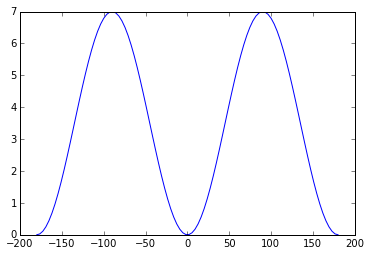

In [29]:
"# Uncomment and run to generate motif dataframes
"""
gtA_B1HTF_sites = pat_hit_motif_dict(motif_locs,gtA_subtr_fdr1_pk,filter_by='SOLEXA')
gtA_B1HTF_sites.to_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtA_B1HTF_sites.csv")

gtP_B1HTF_sites = pat_hit_motif_dict(motif_locs,gtP_subtr_fdr1_pk,filter_by='SOLEXA')
gtP_B1HTF_sites.to_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtP_B1HTF_sites.csv")

gtND_B1HTF_sites = pat_hit_motif_dict(motif_locs,[x[6] for x in fdr1_notcp_highpkbind],filter_by='SOLEXA')
gtND_B1HTF_sites.to_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtND_B1HTF_sites.csv")
"""

"""
gtA_B1HTF_sites = pd.read_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtA_B1HTF_sites.csv")
gtP_B1HTF_sites = pd.read_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtP_B1HTF_sites.csv")
gtND_B1HTF_sites = pd.read_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtND_B1HTF_sites.csv")
"""

"""
#APNDpks = list(gtA_subtr_fdr1_pk) + list(gtP_subtr_fdr1_pk) + [x[6] for x in fdr1_notcp_highpkbind]
#print "A: %d P: %d ND: %d Tot: %d" % (len(gtA_subtr_fdr1_pk),len(gtP_subtr_fdr1_pk),len(fdr1_notcp_highpkbind),len(APNDpks))
#notAPNDpks = [x for x in gtm_un0_pks if x not in APNDpks]
gtAll_B1HTF_sites = pat_hit_motif_dict(motif_locs,gtm_un0_pks,filter_by='SOLEXA')
#gtAll_B1HTF_sites = pd.concat([gtAll_B1HTF_sites,gtA_B1HTF_sites,gtP_B1HTF_sites,gtND_B1HTF_sites],ignore_index=True)
gtAll_B1HTF_sites.to_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtAll_B1HTF_sites.csv")

gtAll_B1HTF_sites = pd.DataFrame.from_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtAll_B1HTF_sites.csv")
print gtAll_B1HTF_sites.head()
gtAll_B1HTF_sites = pat_hit_motif_dict(motif_locs,gtm_un0_pks)
gtAll_B1HTF_sites.columns = pd.Index(['matrix','motif_end','motif_start','chr','end','start','summit','pval','pval_cutoff','score','score_cutoff','strand','TF'])
gtAll_B1HTF_sites.to_csv("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtAll_B1HTF_sites_2.csv")
"""

In [23]:
gtAll_B1HTF_sites = pd.read_csv("/Users/barricklab/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/motifs/gtAll_B1HTF_sites_2.csv",\
                                header=0,\
                                names=['matrix','motif_end','motif_start','CHR','END','START','SUMMIT','pval','pval_cutoff','score','score_cutoff','strand','TF'])
print gtAll_B1HTF_sites.head()

                    matrix  motif_end  motif_start CHR   END  START  SUMMIT  \
0  Espl_FlyReg_FBgn0000591         69           57  2L  6062   5699    5892   
1  Espl_FlyReg_FBgn0000591         82           70  2L  6062   5699    5892   
2  Espl_FlyReg_FBgn0000591        100           88  2L  6062   5699    5892   
3  Espl_FlyReg_FBgn0000591        124          112  2L  6062   5699    5892   
4  Espl_FlyReg_FBgn0000591        156          144  2L  6062   5699    5892   

   pval  pval_cutoff  score  score_cutoff strand    TF  
0 -4.20       -5.305   1.34           0.0      +  ESPL  
1 -4.12       -5.305   1.07           0.0      -  ESPL  
2 -3.88       -5.305   0.75           0.0      -  ESPL  
3 -3.67       -5.305   0.39           0.0      +  ESPL  
4 -3.88       -5.305   0.75           0.0      -  ESPL  


In [25]:
lott2011_df = pd.read_csv("/Users/barricklab/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/enhancers/Lott2011_DataS1.TXT",sep="\t")
print lott2011_df['NAME'].head()
lott2011_df['NAME'] = [str(x).upper() for x in lott2011_df['NAME']]
lott2011_df["pre14expr"] = lott2011_df[["F10","F11","F12","U13","M10","M11","M12","M13"]].sum(axis=1)
lott2011_df["stg14expr"] = lott2011_df[["F14A","U14A","F14B","F14B_r2","F14C","F14C_r2","F14D","M10","M11","M12","M13"]].sum(axis=1)

print lott2011_df[["NAME","CHR","BEG","END","CLASS","F10","F11","F12","U13","M10","M11","M12","M13","pre14expr"]].head().to_string()
print "========"
print lott2011_df[["NAME","CHR","BEG","END","CLASS","F14A","U14A","F14B","F14B_r2","F14C","F14C_r2","F14D","M10","M11","M12","M13","stg14expr"]].head().to_string()

lott2011_early = lott2011_df[lott2011_df['pre14expr'] > (0.5 * lott2011_df['stg14expr'])]
lott2011_early.drop(['CHR','END'],axis=1,inplace=True)
print lott2011_early.shape
print lott2011_df.shape
gtAll_B1HTF_sites_lott2011flt = gtAll_B1HTF_sites.merge(lott2011_early, left_on='TF', right_on='NAME')
print gtAll_B1HTF_sites_lott2011flt.head().to_string()

print sorted(set(gtAll_B1HTF_sites_lott2011flt['TF']))
print len(set(gtAll_B1HTF_sites_lott2011flt['TF']))
print len(set(gtAll_B1HTF_sites['TF']))

0            128up
1    14-3-3epsilon
2       14-3-3zeta
3            140up
4              18w
Name: NAME, dtype: object
            NAME CHR       BEG       END   CLASS      F10     F11      F12      U13      M10     M11      M12      M13  pre14expr
0          128UP  2R   7924810   7926357     mat   103.24   89.70    95.07    83.99    97.29   76.26    94.38    64.46     704.39
1  14-3-3EPSILON  3R  14068252  14074388     mat  1063.28  957.38  1300.41  1385.28  1257.24  861.66  1230.91  1399.05    9455.21
2     14-3-3ZETA  2R   5987192   5995979     mat   484.54  377.29   610.11   604.96   550.95  312.00   581.16   589.49    4110.50
3          140UP  3R   9949939   9951252  matzyg    15.74    7.80     7.64     2.52    12.81    4.14     6.43     4.26      61.34
4            18W  2R  15999015  16004437     zyg     0.00    0.00     0.03     1.72     0.00    0.00     0.08     0.10       1.93
            NAME CHR       BEG       END   CLASS     F14A     U14A    F14B  F14B_r2     F14C  F14C_

/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                       matrix  motif_end  motif_start CHR   END  START  SUMMIT  pval  pval_cutoff  score  score_cutoff strand     TF   NAME       BEG CLASS  F:M SLOPE    F10    F11    F12    U13   F14A   U14A  F14B  F14B_r2  F14C  F14C_r2  F14D  U14D    M10    M11    M12    M13   M14A  M14A_r2  M14B  M14B_r2  M14C  M14C_r2  M14D  M14D_r2  w1_F10  w1_F11  w1_F12  w1_U13  w1_F14A  w1_U14A  w1_F14B  w1_F14B_r2  w1_F14C  w1_F14C_r2  w1_F14D  w1_U14D  w1_M10  w1_M11  w1_M12  w1_M13  w1_M14A  w1_M14A_r2  w1_M14B  w1_M14B_r2  w1_M14C  w1_M14C_r2  w1_M14D  w1_M14D_r2  cas_F10  cas_F11  cas_F12  cas_U13  cas_F14A  cas_U14A  cas_F14B  cas_F14B_r2  cas_F14C  cas_F14C_r2  cas_F14D  cas_U14D  cas_M10  cas_M11  cas_M12  cas_M13  cas_M14A  cas_M14A_r2  cas_M14B  cas_M14B_r2  cas_M14C  cas_M14C_r2  cas_M14D  cas_M14D_r2  pre14expr  stg14expr
0  GATAd_SANGER_5_FBgn0032223         25           17  2L  6062   5699    5892 -7.95       -8.046   5.94           0.0      -  GATAD  GATAD  10333913   mat   0.97

In [26]:
gtAll_B1HTF_sites_flt = gtAll_B1HTF_sites_lott2011flt[gtAll_B1HTF_sites_lott2011flt['pval'] < gtAll_B1HTF_sites_lott2011flt['pval_cutoff']]

gtAllmrg_B1HTF_sites = pd.merge(gtAll_B1HTF_sites_lott2011flt, gtALL_highbind_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtA_B1HTF_sites = pd.merge(gtAll_B1HTF_sites, gtA_APfdr1_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtP_B1HTF_sites = pd.merge(gtAll_B1HTF_sites, gtP_APfdr1_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtND_B1HTF_sites = pd.merge(gtAll_B1HTF_sites, gtNoBias_highbind_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtBias_B1HF_sites = pd.merge(gtAll_B1HTF_sites, gtBias_APfdr1_pks, on=['CHR','START','END','SUMMIT'], how='right')

gtAllmrg_B1HTF_sites_flt = pd.merge(gtAll_B1HTF_sites_flt, gtALL_highbind_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtA_B1HTF_sites_flt = pd.merge(gtAll_B1HTF_sites_flt, gtA_APfdr1_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtP_B1HTF_sites_flt = pd.merge(gtAll_B1HTF_sites_flt, gtP_APfdr1_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtND_B1HTF_sites_flt = pd.merge(gtAll_B1HTF_sites_flt, gtNoBias_highbind_pks, on=['CHR','START','END','SUMMIT'], how='right')
gtBias_B1HTF_sites_flt = pd.merge(gtAll_B1HTF_sites_flt, gtBias_APfdr1_pks, on=['CHR','START','END','SUMMIT'], how='right')

In [ ]:
gtAll_B1HTF_sites_flt.to_csv(data_out_dir + "motifs/gtAll_B1HTF_sites_Lott_early_TF.tsv",sep="\t")